# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
ls

checkpoint*                            traffic_model.data-00000-of-00001*
examples/                              traffic_model.index*
README.md*                             traffic_model.meta*
signnames.csv*                         Traffic_Sign_Classifier.ipynb*
traffic-class_03.data-00000-of-00001*  traffic-signs-data/
traffic-class_03.index*                visualize_cnn.png*
traffic-class_03.meta*                 writeup_template.md*
traffic-class.data-00000-of-00001*     X_train.npy*
traffic-class.index*                   y_train.npy*
traffic-class.meta*


In [2]:
# Load pickled data
import pickle

folder_name = 'traffic-signs-data/'

training_file = folder_name + 'train.p'
validation_file= folder_name + 'valid.p'
testing_file = folder_name + 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
import numpy as np
import pandas as pd

In [4]:
# Number of training examples
n_train = X_train.shape[0]

# Number of validation examples
n_validation = X_valid.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

# What's the shape of an traffic sign image?
image_shape = X_train.shape[1:]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Exploratory visualization of the dataset

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# Visualizations will be shown in the notebook.
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 6)

Populating the interactive namespace from numpy and matplotlib


/home/dl/anaconda3/envs/sdc/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f', 'test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [6]:
from collections import Counter
cc = Counter(y_train)
x,y = zip(*cc.items())

<Container object of 43 artists>

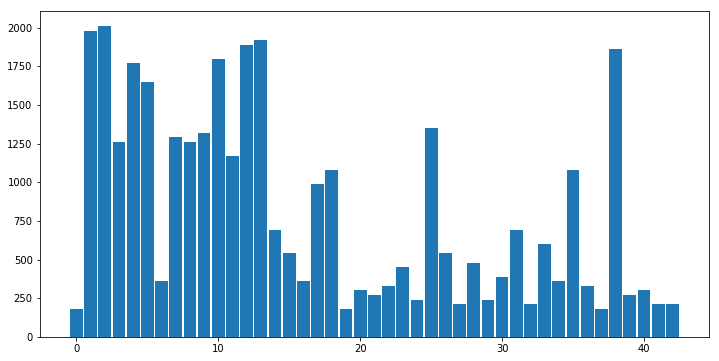

In [7]:
plt.bar(x, y, 0.9)

# Dataset balancing Image Augmentation 

## Augment data using imgaug library

In [8]:
# Library reference https://github.com/aleju/imgaug

In [9]:
from imgaug import augmenters as iaa
import imgaug.imgaug as ia

seq = iaa.Sequential([
    iaa.Crop(px=(2,2,2,2)), # crop images from each side by 0 to 2 px (randomly chosen)
    iaa.Add((-10, 10), per_channel=0.5),
    iaa.Multiply((0.8, 1.2), per_channel=0.5),
    iaa.Affine(
            scale={"x": (0.9, 1.1), "y": (0.9, 1.1)}, # scale images to 80-120% of their size, individually per axis
            translate_px={"x": (-2, 2), "y": (2, 2)}, # translate by -16 to +16 pixels (per axis)
            rotate=(-15, 15), # rotate by -45 to +45 degrees
            shear=(-10, 10), # shear by -16 to +16 degrees
            order=ia.ALL, # use any of scikit-image's interpolation methods
            mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        ),
])

In [10]:
new_number_images_per_class = 7000

print("Max number of image per class {}".format(max(y)))
print("Desired size of the image per class {}".format(new_number_images_per_class))
print("Minimum expected size of new X matrix {}".format(new_number_images_per_class * len(np.unique(y_train))))


Max number of image per class 2010
Desired size of the image per class 7000
Minimum expected size of new X matrix 301000


In [11]:
# Define new X and Y to store values
new_X_train = None
new_y_train = None

In [12]:
# Generating new X and y
if False:
    for index in x: # in every image class
        print('Processing index #{}'.format(index))
        temp_X_real = X_train[y_train == index].copy()
        new_X_matrix = X_train[y_train == index].copy()
        while new_X_matrix.shape[0] < new_number_images_per_class:
            new_X_matrix = np.concatenate((new_X_matrix,seq.augment_images(temp_X_real)))

        if new_X_train is None: # for the first loop
            new_X_train = new_X_matrix.copy()
            new_y_train = np.empty(new_X_matrix.shape[0])
            new_y_train.fill(index)
        else:
            new_X_train = np.concatenate((new_X_train,new_X_matrix))
            new_y_vals = np.empty(new_X_matrix.shape[0])
            new_y_vals.fill(index)
            new_y_train = np.concatenate((new_y_train,new_y_vals))
    # Save result to pickle
    np.save('X_train',new_X_train)
    np.save('y_train',new_y_train)
    print('Pickled the X & y')

### Checkpoint Load augmented data

In [13]:
new_X_train = np.load('X_train.npy')
new_y_train = np.load('y_train.npy')

In [14]:
assert new_y_train.shape[0] == new_X_train.shape[0]

print("Number of new labels: {}".format(new_X_train.shape[0]))

Number of new labels: 316518


In [15]:
X_train, y_train = new_X_train.copy(), new_y_train.copy()

<Container object of 43 artists>

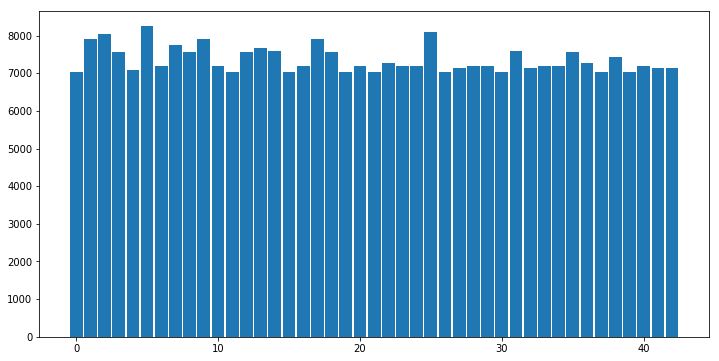

In [16]:
# Visualize augmented dataset distrubution
cc = Counter(y_train)
x,y = zip(*cc.items())
plt.bar(x,y,0.9)

##### Looks better now
---

## Dataset visualisation

In [17]:
sign_names = pd.read_csv('signnames.csv')
print(sign_names.dtypes)
sign_names.head()

ClassId      int64
SignName    object
dtype: object


,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)


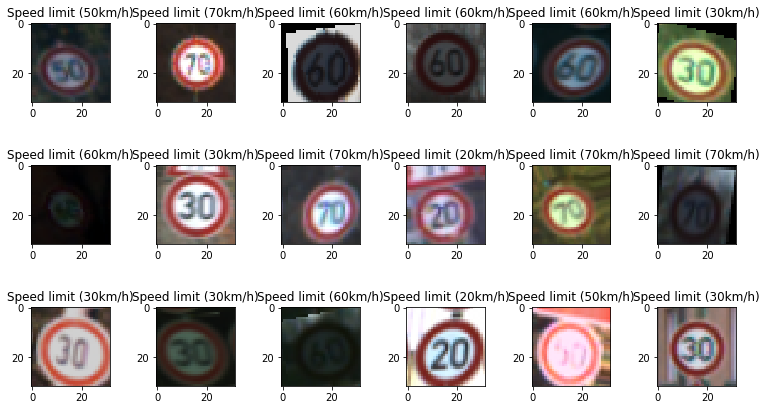

In [18]:
for fig_i,i in enumerate(list(np.random.randint(n_train,size=18))):
    plt.subplot(3,6,int(fig_i)+1)
    plt.imshow(X_train[i])
    plt.title(sign_names.loc[y_train[i],'SignName'])
    
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.8, wspace=0.15)
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [19]:
def normalize(X):
    """Normalize RGB variables such that they are in range of 0 to 1"""
    X = X.astype(np.float)
    return (X - X.min())/(X.max() - X.min())

In [20]:
# Normalizing all images in advance
X_train_normed = normalize(X_train)
X_valid_normed = normalize(X_valid)
X_test_normed = normalize(X_test)
print(X_train_normed.max())
print(X_train_normed.min())
print(X_train_normed.mean())

1.0
0.0
0.320376240689


In [21]:
from sklearn.utils import shuffle

In [22]:
# Shuffle the data in advance
X_train, y_train = shuffle(X_train, y_train)

### Model Architecture

In [23]:
import tensorflow as tf

In [24]:
def conv2d(x_tensor, conv_num_outputs, 
           conv_ksize, conv_strides,
           padding = 'SAME'):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_ksize: kernal size 2-D Tuple for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    with tf.name_scope('conv2d'):
        W = tf.Variable(tf.truncated_normal(shape = (*conv_ksize, x_tensor.get_shape().as_list()[3],conv_num_outputs), 
                                            mean=0.0, 
                                            stddev=0.1,
                                            dtype=tf.float32, 
                                            name = 'conv_W'))
        b = tf.Variable(tf.zeros(conv_num_outputs, 
                                 dtype=tf.float32,
                                 name = 'conv_b'))
        conv = tf.nn.conv2d(x_tensor, W, [1, *conv_strides ,1], padding, name = 'conv2d')
        conv += b
        conv = tf.nn.relu(conv)
        tf.summary.histogram("conv_weights", W)
        tf.summary.histogram("conv_bias", b)
    return conv

In [25]:
def maxpool(x_tensor, pool_ksize, pool_strides, padding = 'SAME'):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_ksize: kernal size 2-D Tuple for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    with tf.name_scope('maxpool'):
        max_pooled_conv = tf.nn.max_pool(x_tensor, [1, *pool_ksize ,1], [1, *pool_strides ,1], padding, name='max_pool')
    return max_pooled_conv

In [26]:
def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    with tf.name_scope('Flatten'):
        return tf.reshape(x_tensor, shape = (-1 ,np.prod(x_tensor.get_shape().as_list()[1:])), name = 'flatten')

In [27]:
def fully_conn(x_tensor, num_outputs):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    with tf.name_scope('FC'):
        W = tf.Variable(tf.truncated_normal(shape = (x_tensor.get_shape().as_list()[1], num_outputs), 
                                            mean=0.0,
                                            stddev=0.1,
                                            dtype=tf.float32, 
                                            name = 'FC_W'))
        b = tf.Variable(tf.zeros(num_outputs, 
                                 dtype=tf.float32,
                                 name = 'FC_b'))
        fc = tf.matmul(x_tensor, W) + b
        fc_act = tf.nn.relu(fc)
        tf.summary.histogram("FC_weights", W)
        tf.summary.histogram("FC_bias", b)
        return fc_act

In [28]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    with tf.name_scope('Output'):
        W = tf.Variable(tf.truncated_normal(shape = (x_tensor.get_shape().as_list()[1], num_outputs), 
                                            mean=0.0,
                                            stddev=0.1,
                                            dtype=tf.float32, 
                                            name = 'Out_W'))
        b = tf.Variable(tf.zeros(num_outputs, 
                                 dtype=tf.float32,
                                 name = 'Out_b'))
        fc = tf.matmul(x_tensor, W) + b
        tf.summary.histogram("Output_weights", W)
        tf.summary.histogram("Output_bias", b)
        return fc

In [29]:
def concatenate(layers, axis):
    """
    Concatenate multiple tensors together
    : layers: Iterable list of tensors
    : return: A tensor of layers concatentated together
    """
    with tf.name_scope('concat'):
        conc = tf.concat([*layers], axis)
    return conc

In [30]:
# Model arch was inspired by Vivek Yadav's post
# https://medium.com/@vivek.yadav/improved-performance-of-deep-learning-neural-network-models-on-traffic-sign-classification-using-6355346da2dc
def conv_net_1(x, keep_prob):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    l0 = conv2d(x, 
                conv_num_outputs = 16, 
                conv_ksize = (1,1), 
                conv_strides = (1,1))

    l1 = conv2d(l0, 
                conv_num_outputs = 48, 
                conv_ksize = (3,3), 
                conv_strides = (1,1))
    l1 = conv2d(l1, 
                conv_num_outputs = 48, 
                conv_ksize = (3,3), 
                conv_strides = (1,1))
    l1 = maxpool(l1,
                pool_ksize  = (2,2), 
                pool_strides = (2,2))
    l1 = tf.contrib.layers.batch_norm(l1)
    
    l2 = conv2d(l1, 
                conv_num_outputs = 64, 
                conv_ksize = (3,3), 
                conv_strides = (1,1))
    l2 = conv2d(l2, 
                conv_num_outputs = 64, 
                conv_ksize = (3,3), 
                conv_strides = (1,1))
    l2 = maxpool(l2,
                pool_ksize  = (2,2), 
                pool_strides = (2,2))
    l2 = tf.contrib.layers.batch_norm(l2)
    
    l3 = conv2d(l2, 
                conv_num_outputs = 96, 
                conv_ksize = (3,3), 
                conv_strides = (1,1))
    l3 = conv2d(l3, 
                conv_num_outputs = 96, 
                conv_ksize = (3,3), 
                conv_strides = (1,1))
    l3 = maxpool(l3,
                pool_ksize  = (2,2), 
                pool_strides = (2,2))
    l3 = tf.contrib.layers.batch_norm(l3)

    flat_l1 = flatten(l1)
    flat_l2 = flatten(l2)
    flat_l3 = flatten(l3)
    
    flat = concatenate([flat_l1, flat_l2, flat_l3], axis = 1)

    flat = tf.nn.dropout(flat, keep_prob)
    
    dense_1 = fully_conn(flat, 4096)
    dense_1 = tf.contrib.layers.batch_norm(dense_1)
    dense_1 = tf.nn.dropout(dense_1, keep_prob)
    
    dense_2 = fully_conn(dense_1, 1024)
    dense_2 = tf.contrib.layers.batch_norm(dense_2)
    dense_2 = tf.nn.dropout(dense_2, keep_prob)
    
    dense_3 = fully_conn(dense_2, 512)
    dense_3 = tf.contrib.layers.batch_norm(dense_3)
    
    return output(dense_3, 43)

In [31]:
tf.reset_default_graph() 

x = tf.placeholder(tf.float32, (None, 32, 32, X_train.shape[3]), name = 'x')
y = tf.placeholder(tf.int32, (None), name = 'y')

with tf.name_scope('keep_prob'):
    keep_prob = tf.placeholder(tf.float32, name='keep_prob')

with tf.name_scope('one_hot'):
    one_hot_y = tf.one_hot(y, len(np.unique(y_train)))

In [32]:
logits = conv_net_1(x, keep_prob)

# Loss and Optimizer
with tf.name_scope('Xent'):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
    loss = tf.reduce_mean(cross_entropy)
    tf.summary.scalar('softmax_cross_entropy_with_logits', loss)
with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer().minimize(loss)
# Accuracy
with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32),name='accuracy')
    tf.summary.scalar('accuracy', accuracy)

In [33]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    """
    Optimize the session on a batch of images and labels
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """
    with tf.name_scope('adam'):
        return session.run([optimizer], feed_dict = {x: feature_batch, y:label_batch, keep_prob: keep_probability})

In [34]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    with tf.name_scope('stats'):
        loss = session.run(cost, feed_dict={x: feature_batch, y: label_batch, keep_prob: 1.})
        t_acc = session.run(accuracy, feed_dict={x: feature_batch, y: label_batch, keep_prob: 1.})
        v_acc = session.run(accuracy, feed_dict={x: X_valid, y: y_valid, keep_prob: 1.})
        print('Loss: {:.5f} Training accuracy: {:.5f} Validation accuracy: {:.5f}'.format(loss,t_acc,v_acc))

# Model Architecture

![Model Arch](misc/arch.png)

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [35]:
import uuid

In [36]:
epochs = 64
batch_size = 256
keep_probability = 0.5

model_id = str(uuid.uuid4())[:8]
print(model_id)

save_model_path = './traffic-class'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    merged_summary = tf.summary.merge_all()
    writer = tf.summary.FileWriter("summary/traffic/" + model_id)
    writer.add_graph(sess.graph)
    c = 0
    # Training cycle
    for epoch in range(epochs):
        for offset in range(0, len(X_train), batch_size):
            end = offset + batch_size
            batch_features, batch_labels = X_train[offset:end], y_train[offset:end]
            train_neural_network(sess, optimizer , keep_probability, batch_features, batch_labels)
            c+=1
            if c % 1000 == 0:
                s = sess.run(merged_summary, feed_dict = {x: batch_features, y: batch_labels, keep_prob: keep_probability})
                writer.add_summary(s, c)
                print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, offset), end='')
                print_stats(sess, batch_features, batch_labels, loss, accuracy)

    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

f48a1eee
Training...
Epoch  1, CIFAR-10 Batch 255744:  Loss: 0.02586 Training accuracy: 0.99219 Validation accuracy: 0.94399
Epoch  2, CIFAR-10 Batch 195072:  Loss: 0.00095 Training accuracy: 1.00000 Validation accuracy: 0.96689
Epoch  3, CIFAR-10 Batch 134400:  Loss: 0.00069 Training accuracy: 1.00000 Validation accuracy: 0.97256
Epoch  4, CIFAR-10 Batch 73728:  Loss: 0.00007 Training accuracy: 1.00000 Validation accuracy: 0.97098
Epoch  5, CIFAR-10 Batch 13056:  Loss: 0.00021 Training accuracy: 1.00000 Validation accuracy: 0.97619
Epoch  5, CIFAR-10 Batch 269056:  Loss: 0.00058 Training accuracy: 1.00000 Validation accuracy: 0.96780
Epoch  6, CIFAR-10 Batch 208384:  Loss: 0.00014 Training accuracy: 1.00000 Validation accuracy: 0.97914
Epoch  7, CIFAR-10 Batch 147712:  Loss: 0.00122 Training accuracy: 1.00000 Validation accuracy: 0.98095
Epoch  8, CIFAR-10 Batch 87040:  Loss: 0.00002 Training accuracy: 1.00000 Validation accuracy: 0.97891
Epoch  9, CIFAR-10 Batch 26368:  Loss: 0.00006

In [37]:
# tf.reset_default_graph()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    num_examples = len(X_test)
    total_accuracy = 0
    BATCH_SIZE = 256
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_test[offset:offset+BATCH_SIZE], y_test[offset:offset+BATCH_SIZE]
        accuracy_score = sess.run(accuracy, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.})
        total_accuracy += (accuracy_score * len(batch_x))
    
#     test_accuracy = sess.run(accuracy, feed_dict={x: X_test, y: y_test, keep_prob: 1.})
    print("Test Accuracy = {:.3f}".format(total_accuracy / num_examples))

Test Accuracy = 0.972


### Distributions
![Distr](misc/distr.png)

### Histograms
![Histogram](misc/hist.png)

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [44]:
import os
import cv2

In [46]:
folder_name = 'google_maps_traffic_signs/'

In [47]:
new_images = None
for image_fname in os.listdir(folder_name):
    temp_img = cv2.imread(folder_name+image_fname)[:,:,[2,1,0]]
    temp_img = cv2.resize(temp_img, (32, 32))
    temp_img = temp_img.reshape((1,temp_img.shape[0],temp_img.shape[1],temp_img.shape[2]))
    if new_images is None:
        new_images = temp_img
    else:
        new_images = np.concatenate((new_images,temp_img))

In [48]:
new_images.shape

(8, 32, 32, 3)

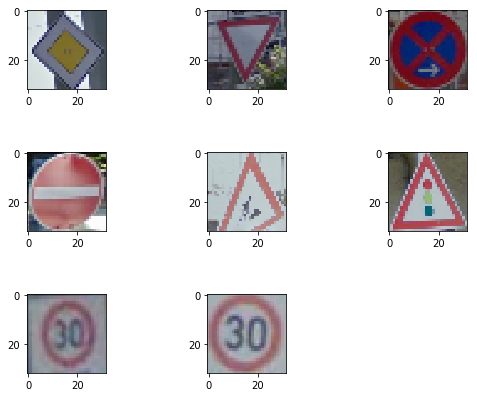

In [49]:
for fig_i,img in enumerate(new_images):
    plt.subplot(3,3,int(fig_i)+1)
    plt.imshow(img)
    
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.7, hspace=0.8, wspace=0.15)
plt.show()

### Predict the Sign Type for Each Image

In [60]:
new_images_normed = normalize(new_images)

In [61]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_accuracy = sess.run(tf.nn.softmax(logits), feed_dict={x: new_images_normed, keep_prob: 1.})

In [62]:
test_accuracy.shape

(8, 43)

### Analyze Performance

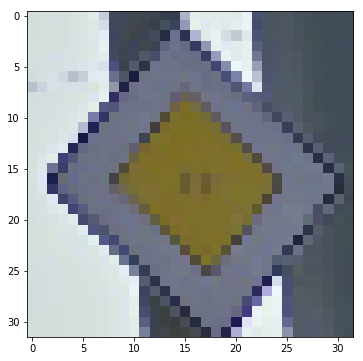

In [63]:
plt.imshow(new_images[0])

In [64]:
test_accuracy_val = test_accuracy.argmax(axis=1)

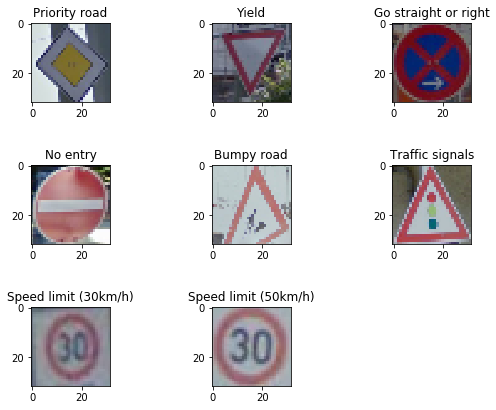

In [65]:
for fig_i,img in enumerate(new_images):
    plt.subplot(3,3,int(fig_i)+1)
    plt.imshow(img)
    plt.title(sign_names.loc[test_accuracy_val[fig_i],'SignName'])
    
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.7, hspace=0.8, wspace=0.15)
plt.show()

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [66]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    new_predictions = sess.run(tf.nn.top_k(tf.nn.softmax(logits),k=3), feed_dict={x: new_images_normed, keep_prob: 1.0})

In [67]:
new_predictions.values

array([[  1.00000000e+00,   4.18240436e-28,   3.84958825e-28],
       [  1.00000000e+00,   2.12958917e-09,   2.59434455e-13],
       [  6.18885219e-01,   2.64492661e-01,   8.30425322e-02],
       [  9.99933243e-01,   6.67681379e-05,   7.65926789e-09],
       [  9.09500599e-01,   8.96496773e-02,   8.24227289e-04],
       [  1.00000000e+00,   1.05073068e-12,   3.86456973e-19],
       [  9.99943495e-01,   5.64344955e-05,   2.55622705e-08],
       [  9.34308767e-01,   6.41870052e-02,   9.24456748e-04]], dtype=float32)

In [68]:
new_predictions.indices

array([[12, 32, 14],
       [13,  3, 28],
       [36, 35, 40],
       [17,  9, 13],
       [22, 20, 25],
       [26, 18, 21],
       [ 1,  4,  0],
       [ 2, 31,  1]], dtype=int32)